## Maestría en Analítica de datos
## Materia Big Data
## Clase 7

*   Nombre: José Luis Ariza
*   Código: 80125197




1.  NODOS
*   (n) => un nodo cualquiera
*   (:Persona) => un nodo con etiquieta Persona
*   (:Persona {nombre:'Luis'}) => un nodo con la propiedad "nombre" que sea igual a "Luis"
2.  REPRESENTACIONES


*   -[r]- => una relación cualquiera
*   -[:TRABAJA_EN]- => una relación de tipo "TRABAJA_EN"
*   -[:AMIGO_DE]- => una relación de tipo "AMIGO_DE"
*   <-[:COMPRO]- =>  una relación entrante de tipo "COMPRO"
3.  PATRONES DE CONSULTA
*  MATCH (a:Persona)-[:AMIGO_DE]->(b:Persona) RETURN a, b








#0.instalar librerias

In [1]:
!pip install neo4j pandas matplotlib networkx pyvis -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.4/325.4 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.0 MB/s eta 0:00:00


#1. instanciar liberias

In [2]:
import pandas as pd
from neo4j import GraphDatabase
import matplotlib.pyplot as plt
import networkx as nx
from pyvis.network import Network
from IPython.display import display, HTML

#2. Configurar la conexión con NEO4J

In [12]:
NEO4J_URI="neo4j+s://f75dbc79.databases.neo4j.io"
NEO4J_USERNAME="neo4j"
NEO4J_PASSWORD="oJrJ5YjaYVrB24NoRZOPNsBmvD56OEXVnJteEELtLXU"
NEO4J_DATABASE="neo4j"
AURA_INSTANCEID="f75dbc79"
AURA_INSTANCENAME="Free instance"


In [13]:
# clase para manejar la conexión con NEO4J
class Neo4jConnection:
    def __init__(self, uri, user, password, database):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
        self.database = database

    def close(self):
        self.driver.close()

    def query(self, query, parameters=None):
        with self.driver.session(database=self.database) as session:
            result = session.run(query, parameters)
            return [record for record in result]

    def execute(self, query, parameters=None):
        with self.driver.session(database=self.database) as session:
            session.run(query, parameters)

In [14]:
def limpiar_bd_neo4j(con):
    con.execute("MATCH (n) DETACH DELETE n")

In [15]:
con = Neo4jConnection(NEO4J_URI, NEO4J_USERNAME, NEO4J_PASSWORD, NEO4J_DATABASE)
print("Conexión establecida con NEO4J")

Conexión establecida con NEO4J


In [17]:
con.execute("""
MATCH (e:Estacion)
DETACH DELETE e
""")

#Ejercicios

## Ejercicio 1 RED DE TRANSMILENIO

In [18]:
estaciones_data = [
    {"nombre": "Portal Norte", "zona": "Norte", "tipo": "Portal"},
    {"nombre": "Calle 100", "zona": "Norte", "tipo": "Intermedia"},
    {"nombre": "Calle 85", "zona": "Norte", "tipo": "Intermedia"},
    {"nombre": "Calle 72", "zona": "Centro", "tipo": "Intermedia"},
    {"nombre": "Heroes", "zona": "Centro", "tipo": "Troncal"},
    {"nombre": "Museo Nacional", "zona": "Centro", "tipo": "Intermedia"},
    {"nombre": "Av. Jimenez", "zona": "Centro", "tipo": "Troncal"},
    {"nombre": "Terreros", "zona": "Sur", "tipo": "Intermedia"},
    {"nombre": "Nariño", "zona": "Sur", "tipo": "Intermedia"},
    {"nombre": "Portal Usme", "zona": "Sur", "tipo": "Portal"}
]

for est in estaciones_data:
    con.execute("""
    CREATE (e:Estacion {nombre: $nombre, zona: $zona, tipo: $tipo})
    """, est)

print(f"Creadas {len(estaciones_data)} estaciones")

Creadas 10 estaciones


In [19]:
#Crear las conexiones
conexiones = [
    ("Portal Norte", "Calle 100", 5),
    ("Calle 100", "Calle 85", 3),
    ("Calle 85", "Calle 72", 4),
    ("Calle 72", "Heroes", 6),
    ("Heroes", "Museo Nacional", 3),
    ("Museo Nacional", "Av. Jimenez", 4),
    ("Av. Jimenez", "Terreros", 5),
    ("Terreros", "Nariño", 4),
    ("Nariño", "Portal Usme", 8)
]

for origen, destino, tiempo in conexiones:
    con.execute("""
    MATCH (e1:Estacion {nombre: $origen})
    MATCH (e2:Estacion {nombre: $destino})
    CREATE (e1)-[:CONECTA_CON {tiempo_minutos: $tiempo}]->(e2)
    CREATE (e2)-[:CONECTA_CON {tiempo_minutos: $tiempo}]->(e1)
    """, {"origen": origen, "destino": destino, "tiempo": tiempo})
print (f" creadas {len(conexiones)}")

 creadas 9


###Consultas

In [20]:
print("Estaciones por zona")
resultado= con.query("""
MATCH (e:Estacion)
RETURN e.zona as Zona, count(e) as Cantidad
ORDER BY Zona
""")
for record in resultado:
    print(f"Zona: {record['Zona']}, Cantidad: {record['Cantidad']}")

Estaciones por zona
Zona: Centro, Cantidad: 4
Zona: Norte, Cantidad: 3
Zona: Sur, Cantidad: 3


In [21]:
print("Ruta más corta entre el portal del Norte y el portal Usme")
resultado= con.query("""
MATCH path = shortestPath(
    (inicio:Estacion {nombre: 'Portal Norte'})-[:CONECTA_CON*]-(fin:Estacion {nombre: 'Portal Usme'})
)
RETURN [n in nodes(path) | n.nombre] as Ruta,
       length(path) as Paradas
""")
print(resultado)
for record in resultado:
    print(f"Ruta: {record['Ruta']}")
    print(f"Paradas: {record['Paradas']}")
    #print(f"Tiempo total: {record['tiempo_total']}")

Ruta más corta entre el portal del Norte y el portal Usme
[<Record Ruta=['Portal Norte', 'Calle 100', 'Calle 85', 'Calle 72', 'Heroes', 'Museo Nacional', 'Av. Jimenez', 'Terreros', 'Nariño', 'Portal Usme'] Paradas=9>]
Ruta: ['Portal Norte', 'Calle 100', 'Calle 85', 'Calle 72', 'Heroes', 'Museo Nacional', 'Av. Jimenez', 'Terreros', 'Nariño', 'Portal Usme']
Paradas: 9


###Visualización del grafo

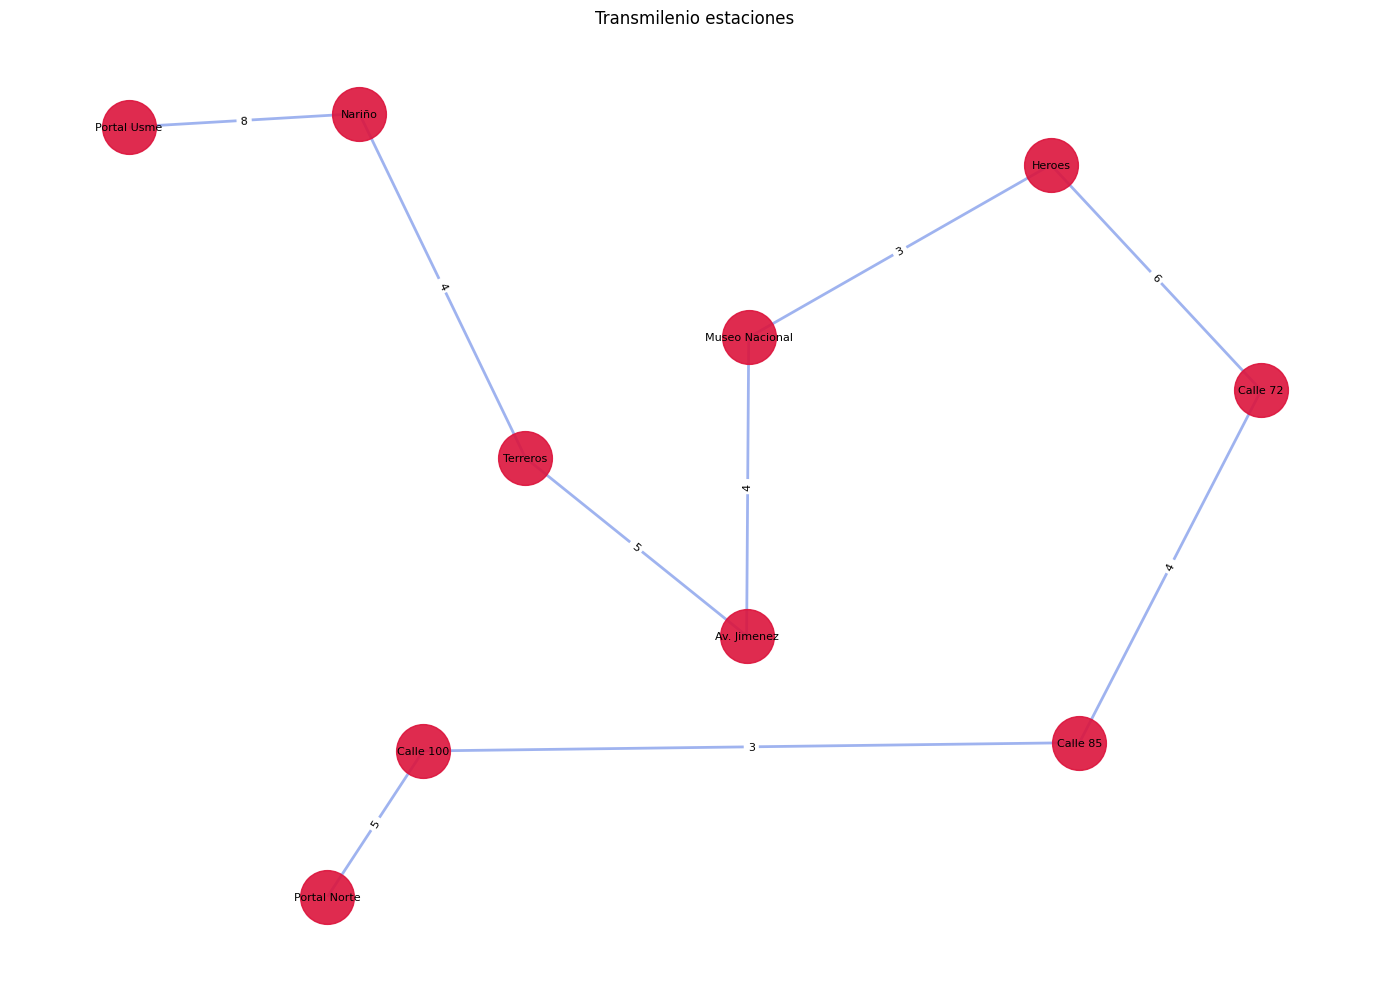

In [22]:
def visualizar_grafo_transmilenio():
  resultado= con.query("""
  MATCH (e1:Estacion)-[r:CONECTA_CON]->(e2:Estacion)
  WHERE id(e1)<id(e2)
  RETURN e1.nombre as Origen, e2.nombre as Destino, r.tiempo_minutos as Tiempo
  """)
  G = nx.Graph()
  for record in resultado:
      G.add_edge(record['Origen'], record['Destino'], weight=record['Tiempo'])

  #-----pinto el grafo----
  plt.figure(figsize=(14, 10))
  pos = nx.spring_layout(G, k=2, iterations=50)

  nx.draw_networkx_nodes(G, pos,node_color='#DC143C', node_size=1500,alpha=0.9)
  nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')
  nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color='#4169E1')
  edge_labels = nx.get_edge_attributes(G, 'weight')
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
  plt.title ("Transmilenio estaciones")
  plt.axis('off')
  plt.tight_layout()
  plt.show()

visualizar_grafo_transmilenio()

##Red doméstica de vuelos (en Colombia)

In [23]:
con.execute("""
MATCH (n)
WHERE n:Aeropuerto OR n:Aerolinea
DETACH DELETE n
""")

###Crear los nodos (aeropuertos)

In [24]:
aeropuertos = [
    {"codigo": "BOG", "ciudad": "Bogotá", "nombre": "El Dorado", "region": "Andina"},
    {"codigo": "MDE", "ciudad": "Medellín", "nombre": "José María Córdova", "region": "Andina"},
    {"codigo": "CLO", "ciudad": "Cali", "nombre": "Alfonso Bonilla Aragón", "region": "Pacífica"},
    {"codigo": "BAQ", "ciudad": "Barranquilla", "nombre": "Ernesto Cortissoz", "region": "Caribe"},
    {"codigo": "CTG", "ciudad": "Cartagena", "nombre": "Rafael Núñez", "region": "Caribe"},
    {"codigo": "SMR", "ciudad": "Santa Marta", "nombre": "Simón Bolívar", "region": "Caribe"},
    {"codigo": "PEI", "ciudad": "Pereira", "nombre": "Matecaña", "region": "Andina"},
    {"codigo": "BGA", "ciudad": "Bucaramanga", "nombre": "Palonegro", "region": "Andina"},
    {"codigo": "CUC", "ciudad": "Cúcuta", "nombre": "Camilo Daza", "region": "Andina"}
]

for aero in aeropuertos:
    con.execute("""
    CREATE (a:Aeropuerto {codigo: $codigo, ciudad: $ciudad,
                          nombre: $nombre, region: $region})
    """, aero)
print(f" se crearon {len(aeropuertos)} aeropuertos")

 se crearon 9 aeropuertos


###Creación de relaciones

In [25]:
# Crear vuelos directos con duración y frecuencia semanal
vuelos = [
    ("BOG", "MDE", 55, 45),  # duración en minutos, frecuencia semanal
    ("BOG", "CLO", 60, 35),
    ("BOG", "BAQ", 90, 30),
    ("BOG", "CTG", 85, 28),
    ("BOG", "PEI", 50, 25),
    ("BOG", "BGA", 45, 20),
    ("BOG", "CUC", 70, 18),
    ("MDE", "CLO", 55, 20),
    ("MDE", "CTG", 75, 15),
    ("MDE", "PEI", 40, 12),
    ("CLO", "CTG", 80, 10),
    ("BAQ", "CTG", 30, 25),
    ("BAQ", "SMR", 40, 20),
    ("CTG", "SMR", 35, 15),
    ("MDE", "BAQ", 80, 12)
]

for origen, destino, duracion, frecuencia in vuelos:
    con.execute("""
    MATCH (a1:Aeropuerto {codigo: $origen})
    MATCH (a2:Aeropuerto {codigo: $destino})
    CREATE (a1)-[:VUELO_DIRECTO {duracion_min: $duracion, frecuencia_semanal: $frecuencia}]->(a2)
    CREATE (a2)-[:VUELO_DIRECTO {duracion_min: $duracion, frecuencia_semanal: $frecuencia}]->(a1)
    """, {"origen": origen, "destino": destino, "duracion": duracion, "frecuencia": frecuencia})
print(f"Se crearon {len(vuelos)} bidireccionales")

Se crearon 15 bidireccionales


###Consultas


In [26]:
# ruta más rapida entre cucuta (CUC) y cartagena (CTG)
resultado= con.query("""
MATCH path = shortestPath(
    (inicio:Aeropuerto {codigo: 'BGA'})-[:VUELO_DIRECTO*]-(fin:Aeropuerto {codigo: 'SMR'})
)
WITH path,
[r in relationships(path) | r.duracion_min] as duracion_min,
[n in nodes(path) | n.ciudad] as ciudades
RETURN ciudades as Ruta, reduce (total=0, x in duracion_min | total + x) as Duracion_total, length(path) as Escalas
""")
for record in resultado:
    print(f"Ruta: {record['Ruta']}")
    print(f"Duración total: {record['Duracion_total']}")
    print(f"Escalas: {record['Escalas']}")

Ruta: ['Bucaramanga', 'Bogotá', 'Barranquilla', 'Santa Marta']
Duración total: 175
Escalas: 3


###Visualización de los grafos

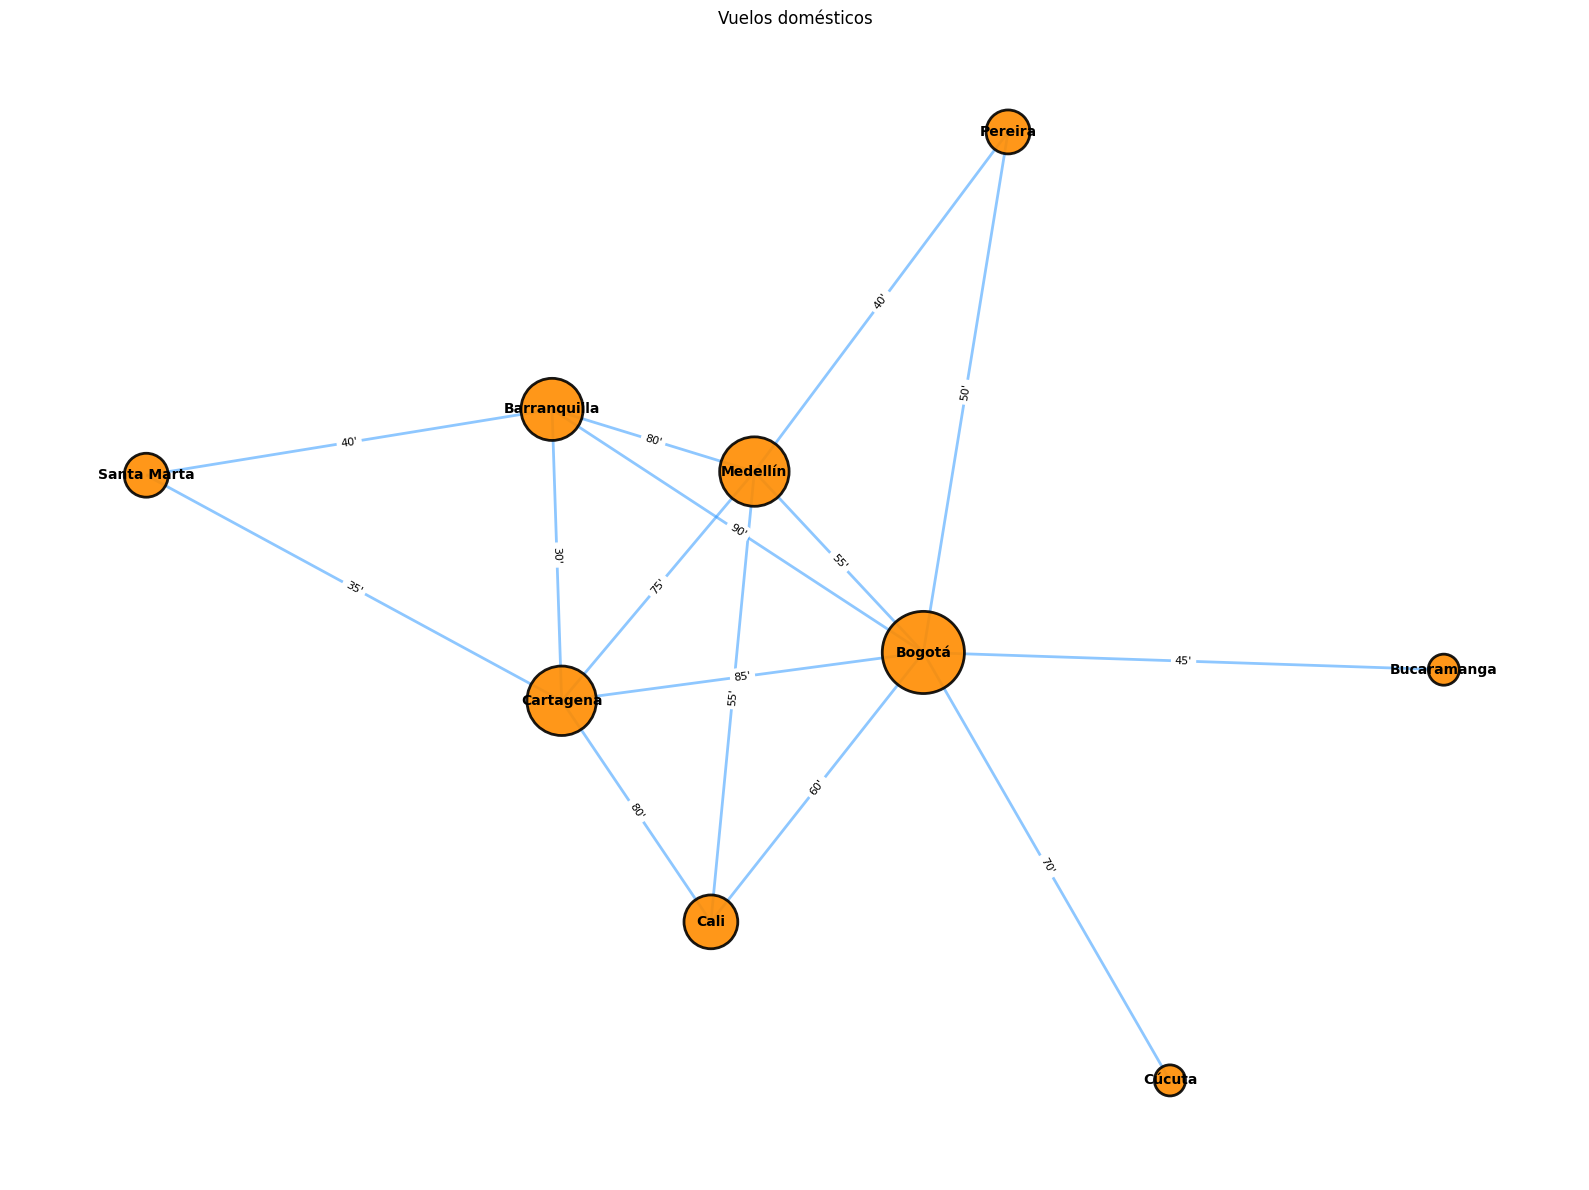

In [27]:
resultado= con.query("""
MATCH (a1:Aeropuerto)-[r:VUELO_DIRECTO]->(a2:Aeropuerto)
WHERE id(a1)<id(a2)
RETURN a1.codigo as origen,a1.ciudad as ciudad_origen,
a2.codigo as destino, a2.ciudad as ciudad_destino,
r.duracion_min as duracion, r.frecuencia_semanal as frecuencia
""")
G = nx.Graph()
for record in resultado:
    G.add_edge(record['ciudad_origen'], record['ciudad_destino'], weight=record['duracion'],frecuencia=record['frecuencia'])
#------codigo para visualizar el grafo
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=3, iterations=50, seed=42)

# Tamaño de nodo basado en conectividad
node_sizes = [G.degree(node) * 500 for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_color='#FF8C00',
                      node_size=node_sizes, alpha=0.9,
                      edgecolors='black', linewidths=2)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color='#1E90FF')

edge_labels = {(u, v): f"{d['weight']}'" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)
plt.title("Vuelos domésticos")
plt.axis('off')
plt.tight_layout()
plt.show()
